# Prerequisite
This notebook requires the following package to execute fully :

* beta-ntf (https://code.google.com/archive/p/beta-ntf/)
* groupNMF (https://github.com/rserizel/groupNMF)
        
Note: group-NMF is not required if you just load the pre-computed dictionnaries


# General imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_digits
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, scale

from beta_ntf import BetaNTF
from tnmf import SupervisedDL


/home/rserizel/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading data

We start by loading the scikit learn toy digits dataset and
creating one train-test split of equal size. 

In [2]:
digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=123)

# Feature learning with unsupervised NMF


Before introducing the supervised model lets start by presenting the unsupervised equivalent: an NMF followed by a logistic regression.
We fit a nonnegative matrix factorizationon the training images and keep the projections for classification



In [3]:
nmf = BetaNTF(data_shape=X_train.shape, n_components=10, 
                                   n_iter=100, verbose=False, beta=2)
nmf.fit(X_train)
W_uns = nmf.factors_[1]
H_train = nmf.factors_[0]


nmf = BetaNTF(data_shape=X_test.shape, n_components=10, 
                                   n_iter=100, verbose=False, beta=2)
nmf.fixed_factors = [1]
nmf.factors_[1]  = W_uns
nmf.fit(X_test)
H_test = nmf.factors_[0]

Fitting NTF model with 100 iterations....
Done.
Fitting NTF model with 100 iterations....
Done.


In [4]:

clf = LogisticRegression(C=10,  multi_class='multinomial', solver='lbfgs')
clf.fit(H_train,y_train)
y_pred = clf.predict(H_test)

print(" Accuracy score for NMF with logisitc regression : %0.2f \n"%accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

 Accuracy score for NMF with logisitc regression : 0.91 

             precision    recall  f1-score   support

          0       0.97      0.98      0.97        94
          1       0.88      0.80      0.83        88
          2       0.95      0.97      0.96        93
          3       0.86      0.85      0.86        80
          4       0.93      0.97      0.95       101
          5       0.96      0.94      0.95        97
          6       0.97      0.97      0.97        93
          7       0.96      0.98      0.97        90
          8       0.83      0.81      0.82        78
          9       0.81      0.85      0.83        85

avg / total       0.91      0.91      0.91       899



# Supervised feature learning with TD-NMF

Before applying the supverised model we need to make sure the labels are integers in between 0 and (n_labels-1)

In [5]:
lb  = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

For the digits toy problem, we use the model in its most basic formulation: without group similarity constraints.
Once the model is initialized, it is used similarly to scikit-learn classifier with the fit and predict functions. 

The most important parameters to tune are: 

_ "n_components" -> the size of the dictionary.

_ "mu" -> to constrain the weights of the classifier and prevent overfitting (equivalent of the "C" parameter in scikit-learn models). 

_ "rho" -> to control the initial gradient step. Should be modified if the cost increases or decreases to slowly.
  
    
    

In [6]:

tdnmf = SupervisedDL(data=X_train, n_components=10, n_labels=10, pos=True, n_iter=10,
                     batch_size=1, agreg=1,rho =0.001)

tdnmf.fit(X_train, y_train, X_test, y_test)
y_pred = tdnmf.predict(X_test)
W_sup = tdnmf.D


print(" Accuracy score for NMF with logisitc regression : %0.2f \n"%accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

/home/rserizel/anaconda2/lib/python2.7/site-packages/spams.py:424: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if D == None:


 Accuracy score for NMF with logisitc regression : 0.94 

             precision    recall  f1-score   support

          0       0.96      0.97      0.96        94
          1       0.89      0.97      0.93        88
          2       0.99      0.86      0.92        93
          3       0.92      1.00      0.96        80
          4       0.98      0.98      0.98       101
          5       0.99      0.93      0.96        97
          6       0.97      0.98      0.97        93
          7       1.00      0.99      0.99        90
          8       0.84      0.87      0.86        78
          9       0.89      0.89      0.89        85

avg / total       0.95      0.94      0.94       899



# Introducing TG-NMF 


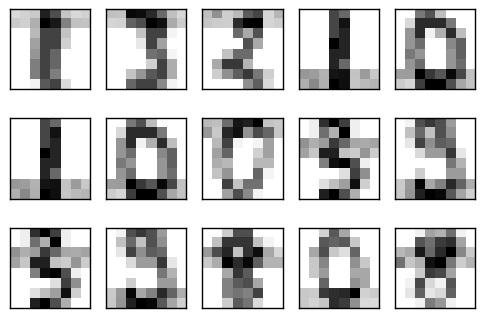

In [5]:
digits = load_digits()
X, y = digits.data, digits.target

L = len(X)/4
X = X[:4*L,:]
y = y[:4*L] 
sessions = np.zeros(y.shape)

for i in range(4):
    X[i*L:(i+1)*L,i*16:(i+1)*16] += (3+2*np.abs(np.random.randn(L,16)))
    sessions[i*L:(i+1)*L] += i
X_train, X_test, y_train, y_test, sessions_train, sessions_test = train_test_split(X, y, sessions, test_size=.5, random_state=123)

fig, ax = plt.subplots(3, 5, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(5):
    for i in range(3):
        im = ax[i, j].imshow(X_train[i*3 +j,:].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest') 

## Pretrain dictionnary with GNMF

In [18]:
from beta_nmf_class import ClassBetaNMF
nmf = ClassBetaNMF(
    X_train, y_train, sessions_train, n_components=(1, 1, 1), beta=2, NMF_updates='groupNMF',
    n_iter=100, normalize=True, verbose=0)
nmf.fit(X_train, y_train, sessions_train)
D = nmf.select([0, 1])
lbl = nmf.iters['cls'][:]

Group NMF with class specific rules for beta-divergence
Compute contraint distances at each segment update
Reordering data...
Fitting NMF model with 100 iterations....
Total duration=2573.0ms


## Alternatively load pre-computed dictionnaries

In [31]:
# ajouter un wget ici pour aller chercher les données
D = np.load('gnmf_dic.npy')
lbl = np.load('gnmf_lbl.npy')

In [32]:
ntf = BetaNTF(data_shape=X_train.shape, n_components=10, 
                                   n_iter=100, verbose=False, beta=2)
ntf.fit(X_train)
W_uns = ntf.factors_[1]
H_train = ntf.factors_[0]


ntf = BetaNTF(data_shape=X_test.shape, n_components=10, 
                                   n_iter=100, verbose=False, beta=2)
ntf.fixed_factors = [1]
ntf.factors_[1]  = W_uns
ntf.fit(X_test)
H_test = ntf.factors_[0]

clf = LogisticRegression(C=10,  multi_class='multinomial', solver='lbfgs')
clf.fit(H_train,y_train)
y_pred = clf.predict(H_test)

print(" Accuracy score for NMF with logisitc regression : %0.2f \n"%accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Fitting NTF model with 100 iterations....
Done.
Fitting NTF model with 100 iterations....
Done.
 Accuracy score for NMF with logisitc regression : 0.84 

             precision    recall  f1-score   support

          0       0.98      0.89      0.93        94
          1       0.76      0.74      0.75        90
          2       0.82      0.87      0.84        89
          3       0.85      0.80      0.82        85
          4       0.91      0.87      0.89       104
          5       0.90      0.89      0.89        97
          6       0.89      0.94      0.91        84
          7       0.84      0.88      0.86        94
          8       0.66      0.68      0.67        74
          9       0.77      0.80      0.79        87

avg / total       0.84      0.84      0.84       898



In [33]:
from tgnmf import SupervisedDL
tdnmf = SupervisedDL(data=X_train, n_labels=10, pos=True, n_iter=2,
                     batch_size=1, agreg=1,rho =0.00001, lbl=lbl,
                     max_iter_init=5, max_iter_fin=5,
                     ses_train=sessions, sub_dict_size=2,  k_cls=1, 
                     k_ses=1,  nu1=0.00001, nu2=0.000001)
tdnmf.D = D
tdnmf.fit(X_train, y_train, X_test, y_test)
y_pred = tdnmf.predict(X_test)
W_sup = tdnmf.D


print(" Accuracy score for NMF with logisitc regression : %0.2f \n"%accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

 Accuracy score for NMF with logisitc regression : 0.95 

             precision    recall  f1-score   support

          0       1.00      0.99      0.99        94
          1       0.94      0.97      0.95        90
          2       0.96      0.98      0.97        89
          3       0.95      0.89      0.92        85
          4       0.99      0.99      0.99       104
          5       0.97      0.95      0.96        97
          6       0.97      0.99      0.98        84
          7       0.96      0.98      0.97        94
          8       0.94      0.82      0.88        74
          9       0.86      0.94      0.90        87

avg / total       0.95      0.95      0.95       898

